# ANALYSIS OF Metformin

This notebook explores the possibility of an intelligen patch to manage levels of metformin in the treatment of diabetes. The analysis develops a closed loop system using the model developed in "Physiologically based metformin pharmacokinetics model of mice and scale-up to humans for the estimation of concentrations in various tissues" by 
Darta Maija Zake, Janis Kurlovics, Linda Zaharenko, Vitalijs Komasilovs, Janis Klovins, Egils Stalidzans
in PLOS ONE , 4/ 2021 , Volume 16 , Issue 4 , pages: e0249594 , DOI: 10.1371/journal.pone.0249594. The model developed in this paper are quite accurate in predicting metformin levels, as shown below. This is BioModels ``BIOMD0000001039``.


<img src="images/metformin-model-fits.png"
     alt="Markdown Monster icon" 
     width="800" height="1000"
     style="float: left; margin-right: 10px;" />

<img src="images/model_overview.png"
     alt="Markdown Monster icon" 
     width="800" height="1000"
     style="float: left; margin-right: 10px;" />

In [1]:
from controlSBML import ControlSBML

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# 1. Problem Statement & System Definition

The biological problem we address is controlling metformin in the kidney, a key consideration since the only case where metformin is counterindicated for the treatment of diabetes is in the case of kidney disease. The idea is to develop an "intelligent patch" that would regulate the level of metformin to better manage diabetes patients with kidney disease.
* Regulate metformin in kidney tissue
* Very fast settling times

Here is a plot of the floating species.

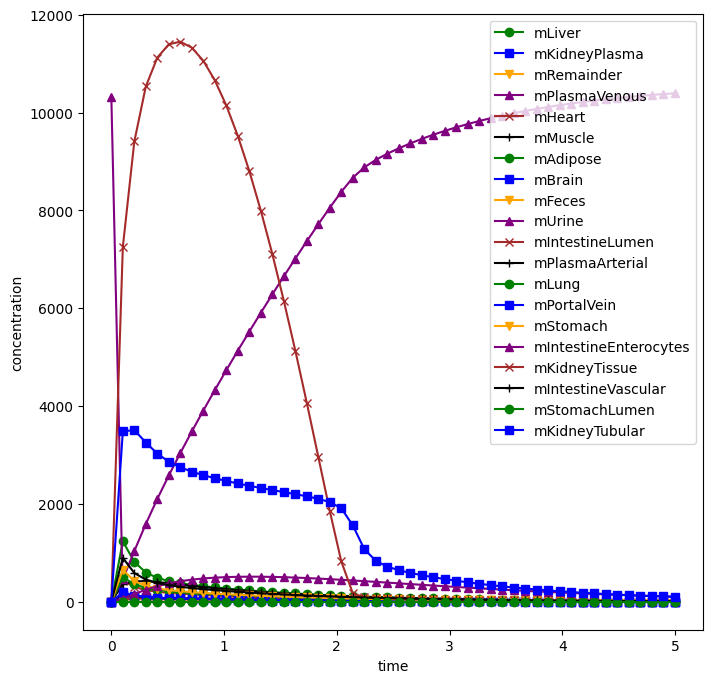

In [2]:
URL = "https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000001039.5?filename=Zake2021_Metformin%2BMice%2BIV.xml"
CTLSB = ControlSBML(URL)
_ = CTLSB.plotModel(figsize=(8,8))

A system is defined by its inputs, outputs, and operating point. The latter refers to the range of inputs over which the system operates. We have specified the output in our problem statement. Our goal is to regulate metformin in the kidney

We begin by selecting an input. The possible inputs can be determined by creating a ``ControlSBML`` object for the model, and listing candidate inputs.

In [3]:
print(CTLSB.getPossibleInputs())

floating_species:	mLiver, mKidneyPlasma, mRemainder, mPlasmaVenous, mHeart, mMuscle, mAdipose, mBrain, mFeces, mUrine, mIntestineLumen, mPlasmaArterial, mLung, mPortalVein, mStomach, mIntestineEnterocytes, mKidneyTissue, mIntestineVascular, mStomachLumen, mKidneyTubular

parameter:	Metformin_Dose_in_Lumen_in_mg, Body_Weight, Metformin_Dose_in_Plasma_in_mg, Cardiac_Output, Ktp_Liver, Ktp_Brain, Ktp_Adipose, Ktp_Heart, Ktp_Kidney, Ktp_Muscle, Ktp_Remainder, Ktp_Lung, Ktp_Stomach, Ktp_IntestineVascular, Qgfr, Compartment_10, Compartment_9, Compartment_6, Compartment_7, Compartment_15, Compartment_0, Compartment_17, Compartment_2, Compartment_16, Compartment_19, Compartment_1, Compartment_12, Compartment_8, Compartment_11, Compartment_4, Compartment_13, Compartment_3, Compartment_18, Compartment_14, Compartment_5, ModelValue_1, ModelValue_3, ModelValue_0, ModelValue_37, ModelValue_34, ModelValue_47, ModelValue_36, ModelValue_35

assignment:	QAdipose, QBrain, QHeart, QKidney, QMuscle, QRema

We use ``mPlastArterial`` as the input since this is informative in terms of an intelligent patch that would control Metformin levels in the kidney.

In [4]:
INPUT_NAME = "mPlasmaArterial"
OUTPUT_NAME = "mKidneyTissue"
CTLSB = ControlSBML(URL, figsize=(5, 5), times=np.linspace(0, 2000, 20000), markers=False,
                   save_path="data.csv", input_names=[INPUT_NAME], output_names=[OUTPUT_NAME])  # Specify default value of options

We next explore the operating region that works well for this model. This is the range of output values (``mKindneyTissue``) that can be used as setpoints and the corresponding input values (``mPlasmaArterial``) that are required to achieve these values.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.



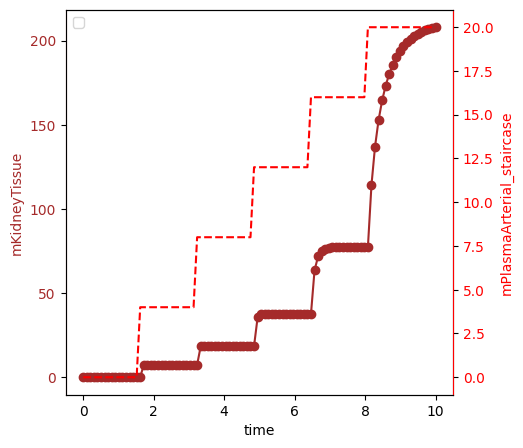

In [5]:
_ = CTLSB.plotStaircaseResponse(initial_value=0, final_value=20, num_step=5, times=np.linspace(0, 10, 100))

# 2. System Identification

System identification describes the system as a transfer function for the operating point specified in system definition. In our system, the input is ``mPlasmaArterial`` and the output is ``mKidneyTissue``. ``mPlasmaArterial`` is varied over the operating region of [0, 25]. The method ``plotTransferFunctionFit`` estimates to transfer function and plots the fit. It returns a Timeseries (a dataframe with the data plotted) and an AntimonyBuilder (the Antimony code run to produce the fitting data).

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.



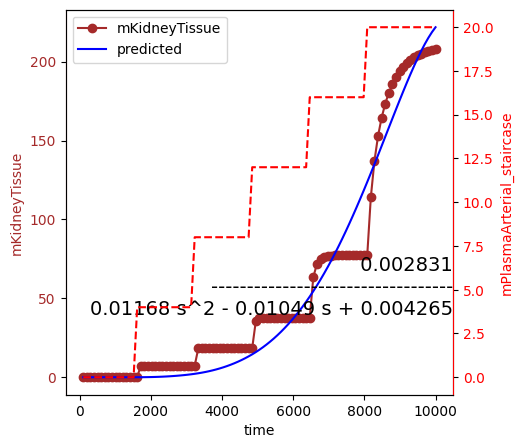

In [6]:
_ = CTLSB.plotTransferFunctionFit(num_zero=1, num_pole=2, initial_value=0, final_value=20,
                                  times=np.linspace(0, 10, 100))

We can obtain the transfer function object.

In [7]:
TRANSFER_FUNCTION = CTLSB.getOpenLoopTransferFunction()
TRANSFER_FUNCTION

TransferFunction(array([0.00283063]), array([ 0.01168153, -0.01049099,  0.00426475]))

In [8]:
TRANSFER_FUNCTION.poles(), TRANSFER_FUNCTION.zeros()

(array([0.4490418+0.40428521j, 0.4490418-0.40428521j]),
 array([], dtype=complex128))

Note that at first glance this seems to be an unstable system since there is a pole in the right hand side of the complex plane. However, this pole is cancelled by a zero at the same location. The result is a first order system.

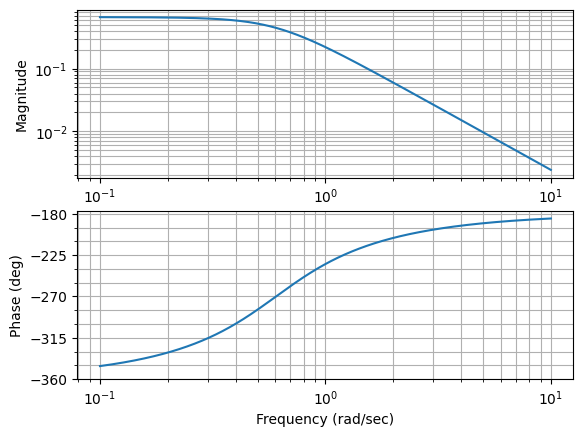

In [9]:
_ = control.bode(TRANSFER_FUNCTION)

In [10]:
TRANSFER_FUNCTION.bandwidth()

0.5727339144690955

Having an infinite bandwidth means that the open loop system is very suspectible to noise.

# 3. Testbed Construction & Control Design

Here, we build a closed loop system where the open loop is the SBML model of the simulated system. Our has a PI controller.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.



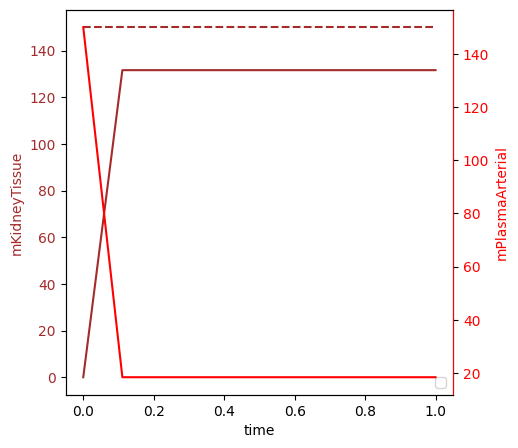

In [11]:
_, builder = CTLSB.plotClosedLoop(setpoint=150, kP=1, times=np.linspace(0, 1, 10))

We are able to simulate the closed loop system, but it's not easy to find design parameters that meet our control objectives.

The root locus plot shows how poles of the closed loop system change when using proportional control. From system identification, we know that the transfer function is

In [12]:
TRANSFER_FUNCTION

TransferFunction(array([0.00283063]), array([ 0.01168153, -0.01049099,  0.00426475]))

The zeros and poles are shown below. Note that the zero is very close to one pole, and so we essentially have pole-zero cancelation.

In [13]:
TRANSFER_FUNCTION.zeros(), TRANSFER_FUNCTION.poles()

(array([], dtype=complex128),
 array([0.4490418+0.40428521j, 0.4490418-0.40428521j]))

The root locus plot shows the position of poles as $k_P$ goes from zero to $\infty$. Closed loop poles start at an open loop pole with $k_P = 0$. 
As $k_P$ gets larger, closed loop poles moved to closed loop zeros, which may be at infinity (as is the case for the "branch" from the smaller pole).

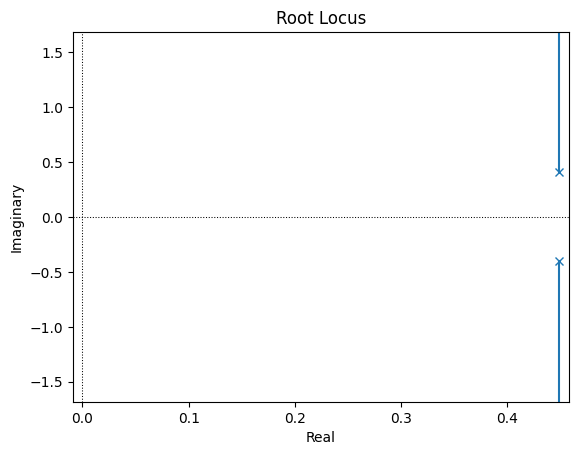

In [14]:
_ = control.rlocus(TRANSFER_FUNCTION, grid=False)

The root locus plot indicates that the closed loop system is stable for large values of $k_P$ since the pole and zero cancel. So, we can get fast, stable control by making $k_P$ very large.

Below, we explore the step response of the system for two different setpoints, and we use a much shorter timescale. We see that settling times are quite fast. The only concern is the amount of overshoot.

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.



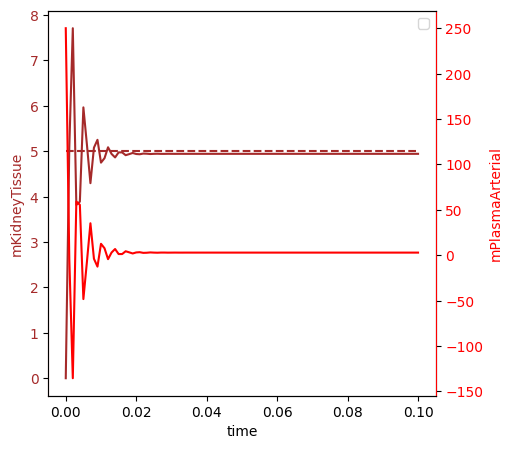

In [15]:
_ = CTLSB.plotClosedLoop(setpoint=5, kP=50, times=np.linspace(0, 0.1, 100))

/Users/jlheller/home/Technical/repos/controlSBML/src/controlSBML/msgs.py:13: UserWarning:



***Warning*** Antimony contains 'unknown_model_qual' which is not supported by tellurium. Replaced with 'description'.



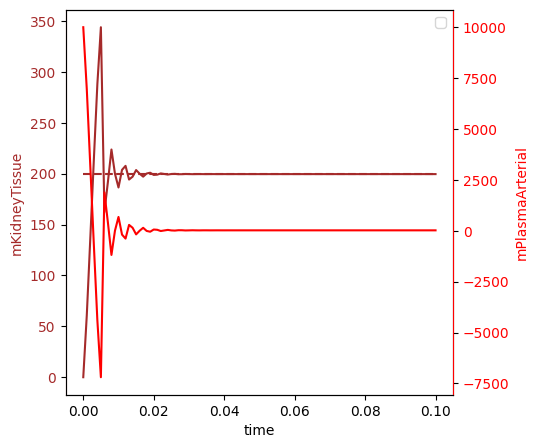

In [16]:
_ = CTLSB.plotClosedLoop(setpoint=200, kP=50, times=np.linspace(0, 0.1, 100))